# Greece exiting bailout: Is the Greek economy strong enough?

by **Ioannis Antypas**

In [133]:
#loading the modules

import pandas as pd
import re
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import numpy as np
pd.set_option('display.max_rows', 500)

# Trade per sector 2010-2017
Source: https://www.statistics.gr/en/statistics/-/publication/SFC02/- 

In [136]:
years = ['17','16','15','14','13']

path ='data_1/trade_'
list_ = []

for year in years:
    file_ = path + year + '.xls'
    df_group = pd.read_excel(file_,  skiprows=6).drop(0)
    df_group = df_group.drop(df_group.columns[2:7], axis = 1)
    df_group.columns = ['codes', 'title_greek','total','eu_trade_value','eu_trade_quantity','third_trade_value','third_trade_quantity','codes_sitc','categories_eng']  
    df_group['year'] = '20' + year
    list_.append(df_group)

frame = pd.concat(list_)

filtered_frame = frame[frame['total'].notnull()].reset_index()

In [137]:
#Second batch
years1 = ['2012','2011','2010']

path1 =r'data_2'
allFiles1 = glob.glob(path1 + "/*.xls")
frame1 = pd.DataFrame()
list_1 = []
counter1 = 2
for file_ in allFiles1:
    df_group1 = pd.read_excel(file_,  skiprows=4)
    df_group1.columns = ['codes', 'categories_gr','country_gr','imports','exports','categories','country','codes']
    df_group1['year'] = years1[counter1]
    counter1 -= 1
    list_1.append(df_group1)
frame1 = pd.concat(list_1)

filtered_frame_1 = frame1[frame1['exports'].notnull()].reset_index()

In [138]:
#cleaning and merging
filtered_frame = frame[frame['total'].notnull()].reset_index()


filtered_frame_cleaned = filtered_frame.drop(['index','codes','title_greek','eu_trade_value','eu_trade_quantity','third_trade_value','third_trade_quantity','codes_sitc'],axis=1)   
filtered_frame_cleaned.columns = ['exports','categories','year']

#named this old to remember its the 2010-2012 period
df_old = filtered_frame_1.groupby(['categories','year']).sum().reset_index().drop(['index','codes'], axis=1)
df_old_cleaned = df_old.drop(['imports'],axis=1)


df_greece = pd.concat([df_old_cleaned,filtered_frame_cleaned], ignore_index=True)

In [139]:
#some wrangling
pd.set_option('float_format', '{:f}'.format)

df_greece['exports'] = df_greece['exports'].astype(int)

df_greece['categories'].replace(r'^.{1}','', regex=True, inplace=True)

df_greece['year'] = df_greece['year'].astype(int)

#percentage change
df_greece['pct_change'] = df_greece['exports'].pct_change()

# Total exports
source: https://www.statistics.gr/en/statistics/-/publication/SFC02/-

In [142]:
#grouping and preparing the data
df_total_exports = df_greece.groupby('year')['exports'].sum()
df_total_exports.to_frame().reset_index(inplace=True)

In [143]:
df_total_exports

year
2010    21299458065
2011    24377308099
2012    27577952124
2013    27295831928
2014    27119691225
2015    25824789408
2016    25463524301
2017    28861650915
Name: exports, dtype: int64

In [144]:
percent_change = (df_total_exports[2017]-df_total_exports[2010])/df_total_exports[2010]
percent_change

0.355041561476461

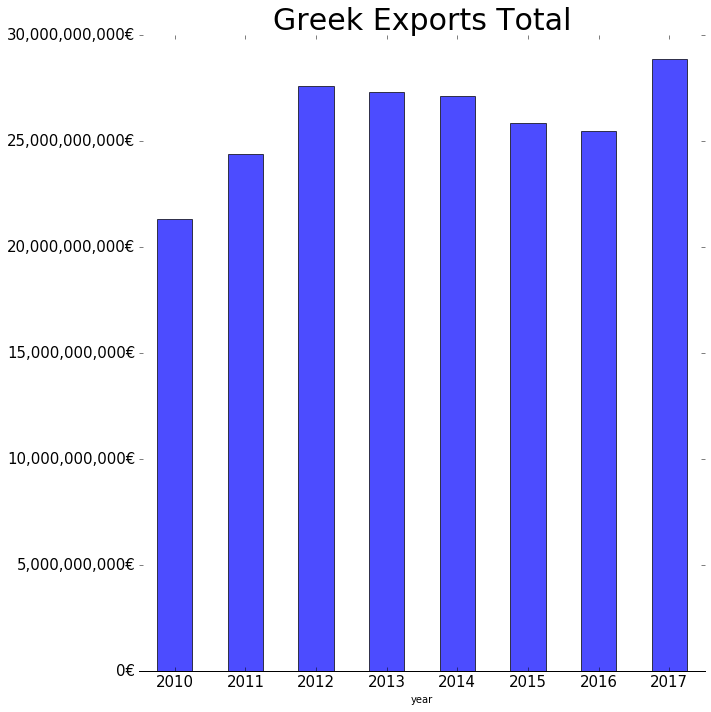

In [167]:
#viz
ax = df_total_exports.plot(kind='bar', x='year',y='exports', align='center', alpha=0.7, rot=0,figsize=(10,10))
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)                           


ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',') + '€')) 


ax.set_title('Greek Exports Total', fontsize=30)
plt.tight_layout()

# plt.savefig('viz/greek_trade_total.pdf')

# # Unit Labour costs
Source ELSTAT - personal request

In [146]:
df_labour = pd.read_csv('unit_labour_costs.csv')

#cleaning the dataset, selecting unitlabour costs, seasonally adjusted
df_labour = df_labour.drop(df_labour[(df_labour.SEASONAL_ADJUST != "Y")].index)
df_labour = df_labour.drop(df_labour[(df_labour.INDICATOR != "LCI_T")].index)

In [147]:
#Splitting the year and grouping them
df_labour_grouped  = df_labour.groupby(['TIME_PERIOD']).mean().reset_index()

df_labour_grouped.TIME_PERIOD = df_labour_grouped.TIME_PERIOD.str.replace('-','')

df_labour_grouped.index = pd.to_datetime(df_labour_grouped.TIME_PERIOD)
df_labour_grouped.TIME_PERIOD['year'] = df_labour_grouped.TIME_PERIOD.index.year

df_labour_grouped = df_labour_grouped.drop(['TIME_PERIOD'],axis=1)

df_labour_grouped.reset_index(inplace=True)

/Users/gcg/.virtualenvs/ddj/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


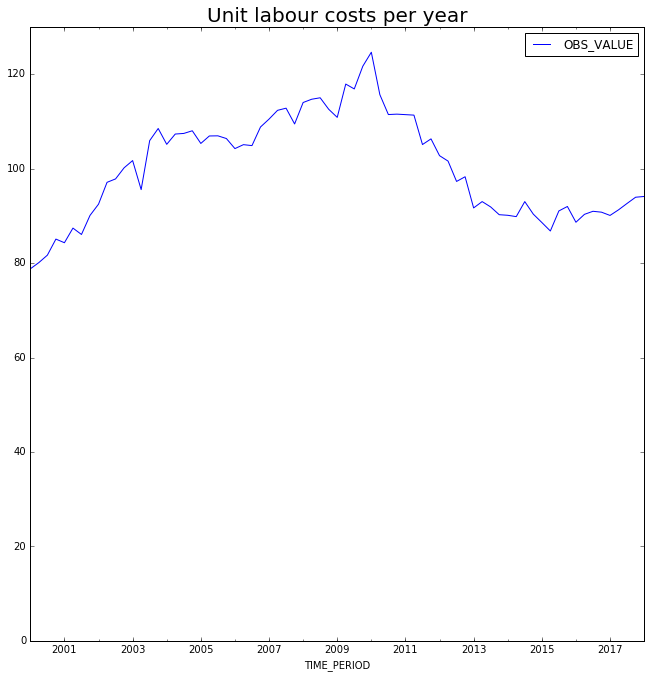

In [148]:
#The value OBS_VALUE measures the percentage change from the base year, 2012. 

ax = df_labour_grouped.plot(x='TIME_PERIOD',y='OBS_VALUE', figsize=(11,11), ylim=(0,130))
ax.set_title('Unit labour costs per year', fontsize=20)
# plt.savefig('viz/labour_costs.pdf')

# Trade Balance
source: https://www.bankofgreece.gr/Pages/en/Statistics/externalsector/balance/basic.aspx

In [149]:
#Importing, and wrangling

df_goods_trade = pd.read_csv('goods_deficit.csv')

df_goods_trade.set_index('date', inplace=True)

df_goods_deficit_test = df_goods_trade.stack().reset_index()

df_goods_deficit_test.columns = ['type', 'date','value']

df_goods_deficit_test['value'] = df_goods_deficit_test['value'].replace(',', '', regex=True)
df_goods_deficit_test['value'] = df_goods_deficit_test['value'].astype(float)

#datetime
df_goods_deficit_test['date'] = pd.to_datetime(df_goods_deficit_test['date'], format="%Y")
df_goods_deficit_test['date'] = df_goods_deficit_test['date'].map(lambda x: x.strftime('%Y'))

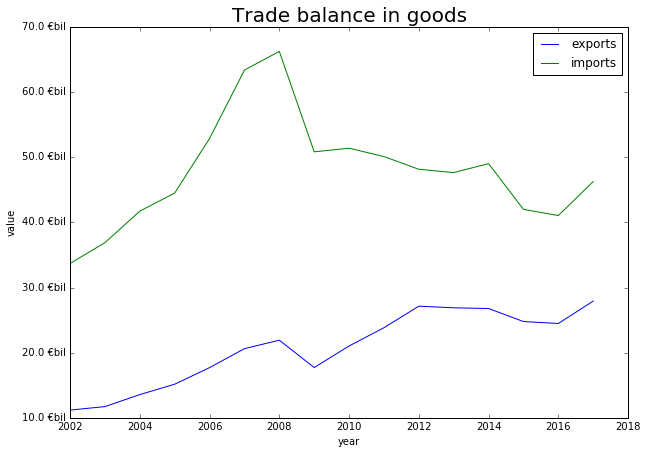

In [150]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,7))

for name in ['exports','imports']:
    ax.plot(df_goods_deficit_test[df_goods_deficit_test.type==name].date,df_goods_deficit_test[df_goods_deficit_test.type==name].value,label=name) 

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x) / 1000, ',') + ' €bil')) 
ax.set_xlabel("year")
ax.set_ylabel("value")
ax.legend(loc='best')
plt.title('Trade balance in goods', fontsize=20)
# plt.savefig('viz/trade_deficit_goods.pdf')

# Trade Jan-May
source: request from elstat

In [151]:
#importing
df_jan_may = pd.read_csv('trade_jan_may.csv')
df_han_may_old = pd.read_csv('trade_jan_may_old.csv')

#cleaning empty rows
df_jan_may = df_jan_may[df_jan_may['YEAR'].notnull()]
df_han_may_old= df_han_may_old[df_han_may_old['YEAR'].notnull()]
df_han_may_old.YEAR = df_han_may_old.YEAR.astype(str)
df_jan_may.DESCR_SITC_EN.replace('^\s','', regex=True)

#concat
df_jan_may = pd.concat([df_jan_may, df_han_may_old], ignore_index=True)
df_jan_may.YEAR.replace('\(\d\)','', regex=True, inplace=True)
df_jan_may.YEAR.replace('\.\d','', regex=True, inplace=True)



#isolating 2010 and 2018
df_jan_may_cleaned = df_jan_may.astype(str)[(df_jan_may.YEAR == '2010') | (df_jan_may.YEAR == '2018')]

In [152]:
df_jan_may_cleaned['VALUE IN EURO'] = df_jan_may_cleaned['VALUE IN EURO'].str.replace(',','')

df_jan_may_cleaned['VALUE IN EURO'] = df_jan_may_cleaned['VALUE IN EURO'].astype(int)



In [153]:
df_jan_may_cleaned = df_jan_may_cleaned.drop(df_jan_may_cleaned[(df_jan_may_cleaned.FLOW != "EXPORTS")].index)

df_jan_may_cleaned = df_jan_may_cleaned.rename(index=str, columns={"VALUE IN EURO": "Exports", 'YEAR':'Year', 'DESCR_SITC_EN':'Type'})

df_jan_may_cleaned['Year'] = df_jan_may_cleaned['Year'].astype(int)



In [154]:
#exporting df_jan_may_cleaned to openrefine to remove white spaces that regex wouldn't replace
df_jan_may_cleaned.to_csv('jan-may-clean-openrefine.csv')
df_jan_may_cleaned = pd.read_csv('jan-may-cleaned.csv')

/Users/gcg/.virtualenvs/ddj/lib/python3.5/site-packages/ipykernel/__main__.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


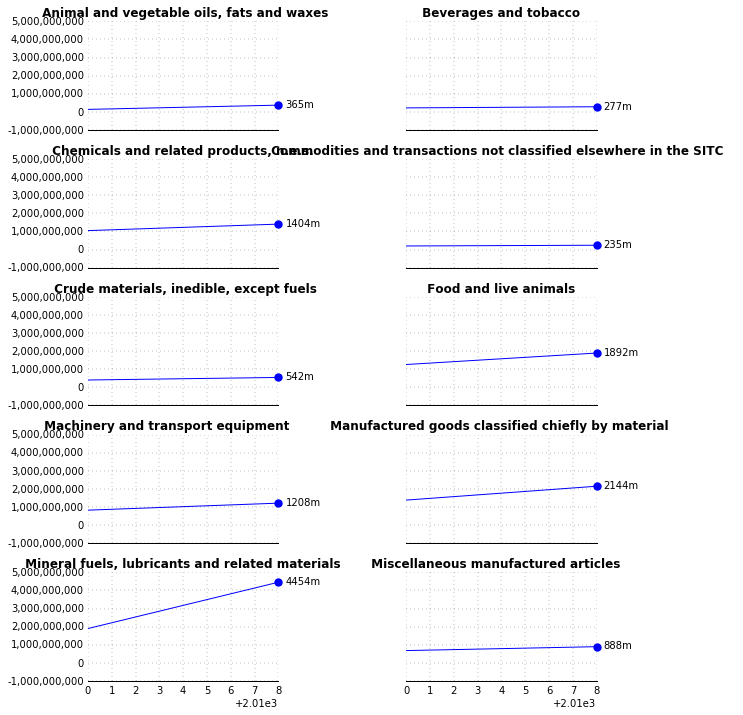

In [155]:
#Small multiples in case we need them

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist] 

grouped = df_jan_may_cleaned.groupby("Type")


ordered_cat_names = grouped['Exports'].last().sort_values(ascending=False).index.sort_values()

first_year = df_jan_may_cleaned['Year'].min()
last_year = df_jan_may_cleaned['Year'].max()

for cat in ordered_cat_names:
    selection = grouped.get_group(cat)

    ax = axes_list.pop(0)
    selection.plot(x='Year', y='Exports', label=cat, ax=ax, legend=False)
    ax.set_title(cat, fontweight="bold")
    ax.tick_params(
            which='both',
            bottom='off',
            left='off',
            right='off',
            top='off')


    ax.grid(linewidth=0.25)
    ax.set_xlim((first_year, last_year))
    ax.set_xlabel("",fontweight="bold", size=15)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))       


    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    max_year = selection['Year'].max()
    value = float(selection[df_jan_may_cleaned['Year'] == max_year]['Exports'])


    ax.scatter(x=[max_year], y=[value], s=70, clip_on=False, linewidth=0)
    ax.annotate(str(int(value / 1000000)) + "m", xy=[max_year, value], xytext=[7, -2], textcoords='offset points')



for ax in axes_list:
    ax.remove()
    


plt.subplots_adjust(hspace=1)


plt.tight_layout()




Now for the line chart

In [156]:
#a bit of cleaning
df_jan_may_cleaned = df_jan_may_cleaned.drop(['SITC_1','DESCR_SITC_GR'], 1)

#turning years into strings
df_jan_may_cleaned.Year = df_jan_may_cleaned.Year.astype(str)

#pivoting
df_jan_may_pivot = df_jan_may_cleaned.pivot_table(index=('Type'),columns='Year',values='Exports')

In [157]:
#pct change for label

df_jan_may_pivot['pct_chng'] = (((df_jan_may_pivot['2018'] - df_jan_may_pivot['2010'])/  df_jan_may_pivot['2010'] ) *100)

df_jan_may_pivot.pct_chng = df_jan_may_pivot.pct_chng.round().astype(int)

df_jan_may_pivot.pct_chng = df_jan_may_pivot.pct_chng.astype(str) + '%'



In [158]:
df_jan_may_pivot['xa']  = 1
df_jan_may_pivot['xb']  = 2

In [159]:
df_jan_may_pivot.reset_index(inplace=True)

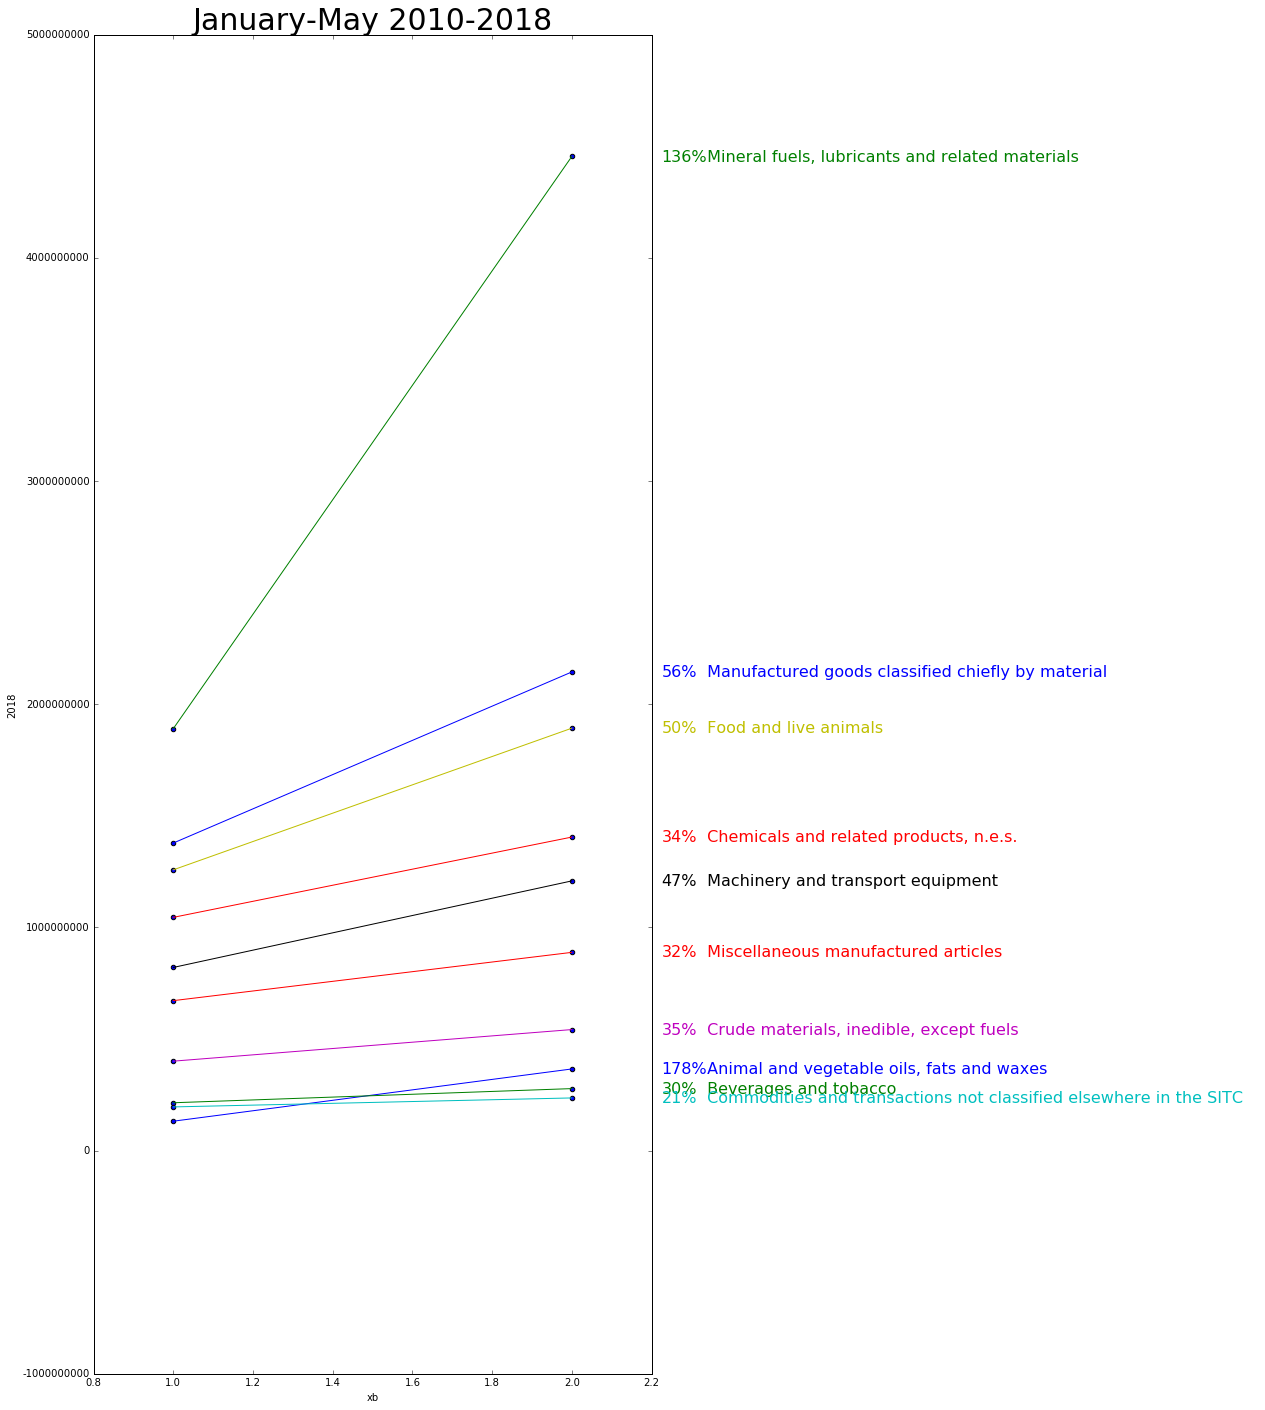

In [160]:
#Slopechart

ax = df_jan_may_pivot.plot(kind='scatter',x='xa', y ='2010', figsize = (18,24))

df_jan_may_pivot.plot(kind='scatter',x='xb', y ='2018', figsize = (10,24), ax=ax)

for row in df_jan_may_pivot.iloc[:, 1:3].itertuples(index=False, name='Pandas'):
    ax.plot([1,2], np.asarray(row))


ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))


for line, name in zip(ax.lines, df_jan_may_pivot.Type):
    y = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,y), xytext=(50,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=16, va="center")

for line, name in zip(ax.lines, df_jan_may_pivot.pct_chng):
    y = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,y), xytext=(10,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=16, va="center")


plt.title('January-May 2010-2018', fontsize=30)

# plt.savefig('viz/slope_jan_may-10-18.pdf', bbox_inches="tight")




# Exports of Goods as a % of GDP
Source: Request to Eurostat

In [161]:
df_percent_gdp = pd.read_csv('exports_goods_GDP.csv')

In [162]:
df_percent_gdp = df_percent_gdp.rename(index=str, columns = {'GEO/TIME':'Member State', '2017':'Exports in 2017'})

In [163]:
df_percent_gdp = df_percent_gdp[['Member State','Exports in 2017']]

In [164]:
df_percent_gdp

,Member State,Exports in 2017
0,European Union (current composition),33.000000
1,European Union (without United Kingdom),35.800000
2,Euro area (19 countries),34.900000
3,Belgium,61.000000
4,Bulgaria,51.100000
5,Czech Republic,67.200000
6,Denmark,34.800000
7,Germany (until 1990 former territory of the FRG),39.000000
8,Estonia,51.700000
9,Ireland,65.600000


In [165]:
df_percent_gdp['dummy'] = df_percent_gdp['Member State'] == 'Greece'
colored = []
colored.append(df_percent_gdp.sort_values('Exports in 2017', ascending=True).dummy.map({True: 'brown', False: '#529ECD'}))

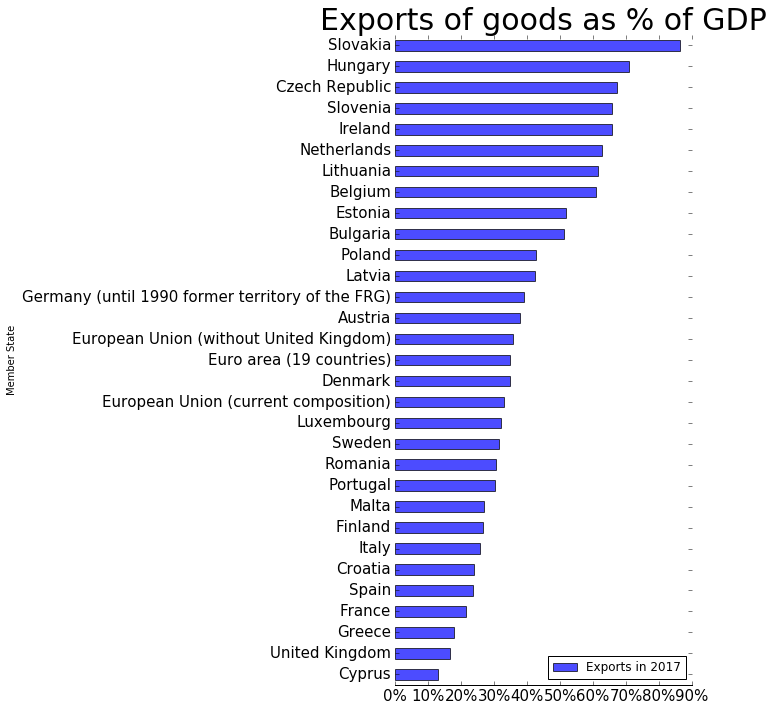

In [166]:
#viz
ax = df_percent_gdp.sort_values('Exports in 2017', ascending=True).plot(kind='barh', x='Member State',y='Exports in 2017', align='center', alpha=0.7, rot=0,figsize=(10,10))
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)                           

ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',') + '%')) 


ax.set_title('Exports of goods as % of GDP', fontsize=30)
plt.tight_layout()

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('viz/Goods_share_GDP.pdf')